In [1]:
# -- coding:utf-8 --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

import utils


def preprocess_time_series():
    data = pd.read_excel('data/time_series_375_prerpocess_en.xlsx', index_col=[0, 1])
    data = data.dropna(thresh=6)
    data.to_parquet('data/time_series_375.parquet')
    data = pd.read_excel('data/time_series_test_110_preprocess_en.xlsx', index_col=[0, 1])
    data.to_parquet('data/time_series_test_110.parquet')


if __name__ == '__main__':
    preprocess_time_series()


/Users/trangle/Documents/github-repos/Pre_Surv_COVID_19/utils.py:110: FutureWarning: 'PATIENT_ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(['PATIENT_ID', 't_diff']).last()
/Users/trangle/Documents/github-repos/Pre_Surv_COVID_19/utils.py:110: FutureWarning: 't_diff' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(['PATIENT_ID', 't_diff']).last()
/anaconda3/envs/tpotDataSel/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


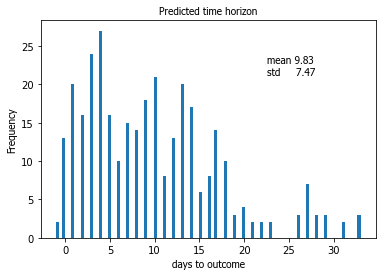

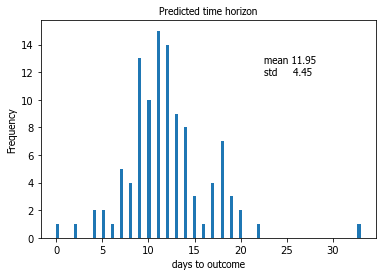

In [2]:
font = {
    'family': 'Tahoma',
    'size': 10
}

data1 = pd.read_parquet('data/time_series_375.parquet')[['Lactate dehydrogenase', 
                                                         'High sensitivity C-reactive protein', '(%)lymphocyte',
                                                         'Discharge time', 'outcome']]
data2 = pd.read_parquet('data/time_series_test_110.parquet')[['Lactate dehydrogenase', 
                                                         'High sensitivity C-reactive protein', '(%)lymphocyte',
                                                         'Discharge time', 'outcome']]
i = 0    
for data in [data1, data2]:
    i = i + 1
    data = data.dropna(how='all', subset=['Lactate dehydrogenase', 'High sensitivity C-reactive protein', '(%)lymphocyte'])

    # 滑窗合并数据
    data = utils.merge_data_by_sliding_window(data, n_days=1, dropna=True, subset=utils.top3_feats_cols, time_form='diff')
    # 根据一级（PATINET_ID）和二级索引（距离出院的时间）排序
    data = data.sort_index(level=(0, 1))

    # 调用apply方法对每个样本进行判断 即 论文决策树预测
    data['pred'] = data.apply(utils.decision_tree, axis=1)

    # 统计提前预测时长
    time_advance = utils.get_time_in_advance_of_predict(data)['time_advance']

    # Figure
    plt.hist(time_advance, bins=100)
    plt.title('Predicted time horizon', fontdict=font)
    plt.xticks(fontsize=font['size'])
    plt.yticks(fontsize=font['size'])
    plt.xlabel('days to outcome', fontdict=font)
    plt.ylabel('Frequency', fontdict=font)
    x_max = plt.gca().get_xlim()[1]
    y_max = plt.gca().get_ylim()[1]
    plt.text(0.65 * x_max, 0.75 * y_max, f"mean {np.mean(time_advance):.2f}\nstd     {np.std(time_advance):.2f}", fontdict=font)
    plt.show()
    
#     data.to_csv(f'data/processed_covid_{i}.tsv', sep = '\t', index = False)


In [5]:
def merge_data_by_sliding_window(data, n_days=1, dropna=True, subset=None, time_form='diff'):
    """滑窗合并数据

    :param data: 时间序列数据，一级行索引为 PATIENT_ID, 二级行索引为 RE_DATE
    :param n_days: 窗口长度
    :param dropna: 滑窗合并后还缺失的是否删掉
    :param subset: pd.DataFrame().dropna() 参数                                                   Note: 新参数!
    :param time_form: 返回数据的时间索引，'diff' or 'timestamp'
    :return: 合并后的数据，一级行索引为 PATIENT_ID, 二级行索引为 t_diff or RE_DATE, 取决于"time_form"
    """
    #根据PATIENT_ID排序
    data = data.reset_index(level=1)
    # dt.normalize() 取Discharge time的天数
    # 距离出院时长        Note: 去掉了Discharge time和检测时间的时分秒，因为我觉得以 00:00:00 为分界点更合适
    t_diff = data['Discharge time'].dt.normalize() - data['RE_DATE'].dt.normalize()
    # 滑窗取整的依据。即nn_days天内的会取整成为同一个数值，后面通过groupby方法分组
    data['t_diff'] = t_diff.dt.days.values // n_days * n_days
    #
    data = data.set_index('t_diff', append=True)

    # 滑窗合并。对['PATIENT_ID', 't_diff']groupby，相当于双循环。遍历所有病人与病人的所有窗口
    # 因为之前对data排序，因此每个病人t_diff会是从大到小的排序,ffill()是向上一行插值，因此相当于是向旧日期插值
    # last()是每一组取最后一行，因此即取每个病人对应窗口的最后一次数据，（也一定是最全的）。
    # last(）自带排序。取完last后会按照索引升序排列
    data = (
        data
        .groupby(['PATIENT_ID', 't_diff']).ffill()
        .groupby(['PATIENT_ID', 't_diff']).last()
    )
    # 去掉缺失样本
    if dropna:
        data = data.dropna(subset=subset)         # Note: 这里对缺失值进行了 dropna(), 而不是 fillna(-1)

    # 更新二级索引。（其实timestamp在本论文的中没用到）
    if time_form == 'timestamp':
        data = (
            data
            .reset_index(level=1, drop=True)
            .set_index('RE_DATE', append=True)
        )
    elif time_form == 'diff':
        data = data.drop(columns=['RE_DATE'])

    return data


In [9]:
################################
## Read data functions
###############################
def read_train_data(path_train):
    data_df = pd.read_excel(path_train, encoding='gbk', index_col=[0, 1])  # train_sample_375_v2 train_sample_351_v4
    data_df = data_df.groupby('PATIENT_ID').last()
    # data_df = data_df.iloc[:,1:]
    # data_df = data_df.set_index(['PATIENT_ID'])
    # data_df['年龄'] = data_df['年龄'].apply(lambda x: x.replace('岁', '') if is_number(x.replace('岁', '')) else np.nan).astype(float)
    # data_df['性别'] = data_df['性别'].map({'男': 1, '女': 2})
    # data_df['护理->outcome'] = data_df['护理->outcome'].map({'治愈': 0,'好转': 0, '死亡': 1})
    lable = data_df['outcome'].values
    data_df = data_df.drop(['outcome', 'Admission time', 'Discharge time'], axis=1)
    data_df['Type2'] = lable
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    # data_df = data_df.loc[:, data_df.isnull().mean() < 0.2]
    data_df = data_df.astype(float)

    return data_df


def data_preprocess():
    path_train = './data/time_series_375_prerpocess_en.xlsx'  # to_ml
    data_df_unna = read_train_data(path_train)

    # data_pre_df = pd.read_csv('./data/sample29_v3.csv',encoding='gbk')
    data_pre_df = pd.read_excel('./data/time_series_test_110_preprocess_en.xlsx', index_col=[0, 1], encoding='gbk')
    data_pre_df = utils.merge_data_by_sliding_window(data_pre_df, n_days=1, dropna=True, subset=utils.top3_feats_cols,
                                                     time_form='diff')
    data_pre_df = data_pre_df.groupby('PATIENT_ID').first().reset_index()
    data_pre_df = data_pre_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_pre_df = data_pre_df.drop_duplicates()

    return data_df_unna, data_pre_df

### is_number in the read data
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

### Data read and split
def data_read_and_split(is_dropna=False,sub_cols=None):
    # data_df_unna为375数据集，data_pre_df为110数据集
    data_df_unna,data_pre_df = data_preprocess()
    if is_dropna==True:
        data_df_unna = data_df_unna.dropna(subset=sub_cols,how='any')

    # 计算特征的缺失情况
    col_miss_data = col_miss(data_df_unna)
    # 计算特征缺失比例
    col_miss_data['Missing_part'] = col_miss_data['missing_count']/len(data_df_unna)
    # 选择缺失少于0.2的特征
    sel_cols = col_miss_data[col_miss_data['Missing_part']<=0.2]['col']
    # copy函数将选择的特征数据摘出来，不影响原数据的数值
    data_df_sel = data_df_unna[sel_cols].copy()
    # 计算所有特征
    cols = list(data_df_sel.columns)
    # 剔除年龄和性别
    cols.remove('年龄')
    cols.remove('性别')
    cols.remove('Type2')
    cols.append('Type2')
    # 构造剔除上述特征的dataframe
    data_df_sel2 = data_df_sel[cols]
    # 新建一个dataframe
    data_df_unna = pd.DataFrame()
    # 类似copy方法，新建变量，修改不会影响原数值
    data_df_unna = data_df_sel2

    # 对缺失数值添-1
    data_df_unna = data_df_unna.fillna(-1)

    # 取出特征名，从第一列到倒数第二列
    x_col = cols[:-1]
    #print(x_col)
    # 取出标签名
    y_col = cols[-1]
    #取出375特征数据
    X_data = data_df_unna[x_col]#.values
    #取出375标签数据
    Y_data = data_df_unna[y_col]#.values

    return X_data,Y_data,x_col



In [18]:
data_df_unna,data_pre_df = data_preprocess()

In [16]:
def col_miss(train_df):
    col_missing_df = train_df.isnull().sum(axis=0).reset_index()
    col_missing_df.columns = ['col','missing_count']
    col_missing_df = col_missing_df.sort_values(by='missing_count')
    return col_missing_df
data_df_unna = data_df_unna.dropna(subset=None,how='any')

# 计算特征的缺失情况
col_miss_data = col_miss(data_df_unna)
# 计算特征缺失比例
col_miss_data['Missing_part'] = col_miss_data['missing_count']/len(data_df_unna)
# 选择缺失少于0.2的特征
sel_cols = col_miss_data[col_miss_data['Missing_part']<=0.2]['col']
# copy函数将选择的特征数据摘出来，不影响原数据的数值
data_df_sel = data_df_unna[sel_cols].copy()
# 计算所有特征
cols = list(data_df_sel.columns)
# 剔除年龄和性别
# cols.remove('年龄')
# cols.remove('性别')
cols.remove('Type2')
cols.append('Type2')
# 构造剔除上述特征的dataframe
data_df_sel2 = data_df_sel[cols]
# 新建一个dataframe
data_df_unna = pd.DataFrame()
# 类似copy方法，新建变量，修改不会影响原数值
data_df_unna = data_df_sel2

In [20]:
data_df_unna.to_csv('data/processed_covid_train.tsv', sep = '\t', index = False)
data_pre_df.to_csv('data/processed_covid_test.tsv', sep = '\t', index = False)